/usr/local/lib/python3.4/dist-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


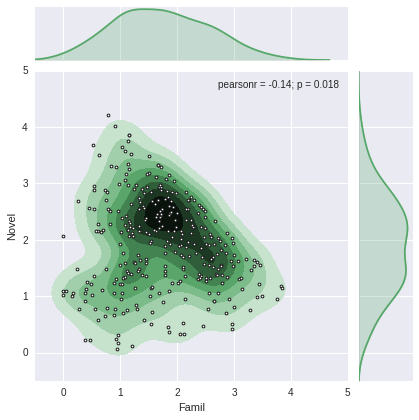

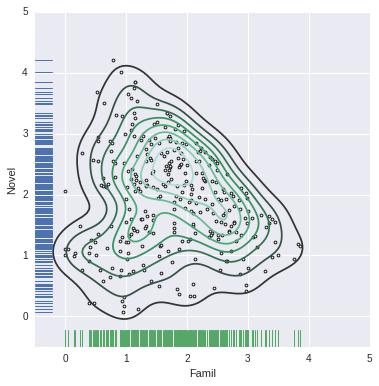

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from theano import tensor as T
%matplotlib inline

# Load data
dat = pd.read_csv('TestPhase.csv')

## Expression bias
FixDur = dat.fixDur
Emo = dat.Emo2
Famil = dat.Famil
Grp = dat.Grp

condi = 2
# The datasets:
if condi == 1:
    x = FixDur[Emo == "FEAR"].values
    y = FixDur[Emo == "HAPPY"].values
    label1 = "FEAR"
    label2 = "HAPPY"
else:
    x = FixDur[Famil == "famil"].values
    y = FixDur[Famil == "novel"].values
    label1 = "Famil"
    label2 = "Novel"

# Descriptive result
sns.set(color_codes=True)
datmp = np.zeros((306, 2))
datmp[:,0]=x
datmp[:,1]=y

df = pd.DataFrame(datmp,columns=["x", "y"])

# sns.jointplot(x="x", y="y", data=df);

g = sns.jointplot(x="x", y="y", data=df, kind="kde", color="g", xlim=(-.5,5), ylim=(-.5,5))
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels(label1, label2);
plt.show()

f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(df.x, df.y, ax=ax)
plt.scatter(df.x, df.y, c="w", s=30, linewidth=1, marker=".")
sns.rugplot(df.x, color="g", ax=ax)
sns.rugplot(df.y, vertical=True, ax=ax);
sns.axlabel(label1, label2);
plt.ylim(-.5,5)
plt.xlim(-.5,5)
plt.show()

# Inferring two Rates under a bounded condition



let $\xi^\star_j \sim \mbox{Gamma}(\alpha_j, 1)$. Then it can be shown that 
$$
\xi \equiv \left(\frac{\xi^\star_1}{\sum_j \xi^\star_j}, \ldots, 
\frac{\xi^\star_J}{\sum_j \xi^\star_j}\right) \sim \mathcal Dirichlet(\alpha_1, \ldots, \alpha_J).
$$

In [2]:
# prepare data
z = 5 - x - y
datmp = np.zeros((306, 3))
x[x == 0] = 5 - 4.999999999999999
y[y == 0] = 5 - 4.999999999999999
z[z <= 0] = 5 - 4.999999999999999

datmp[:,0]=x/5
datmp[:,1]=y/5
datmp[:,2]=z/5

N = len(x)

logp = np.log(datmp)
# logp = logp[np.isfinite(logp[:,2])]
logpk = np.nanmean(logp,axis=0)

dframe = pd.DataFrame(datmp,columns=["x", "y", "z"])
n1,n2 = dframe.shape

 [-----------------100%-----------------] 20000 of 20000 complete in 152.4 secPlotting xi
Plotting yi
Plotting alpha3
Plotting alpha1
Plotting alpha2
Plotting zi


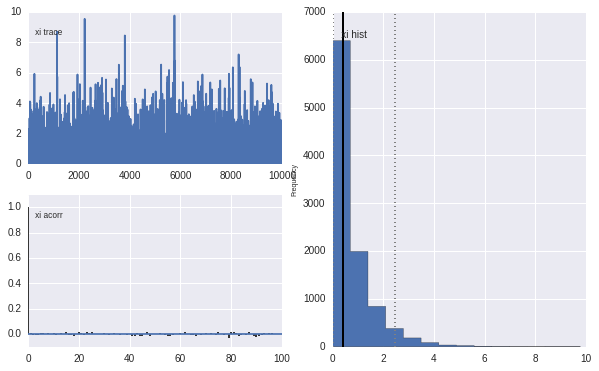

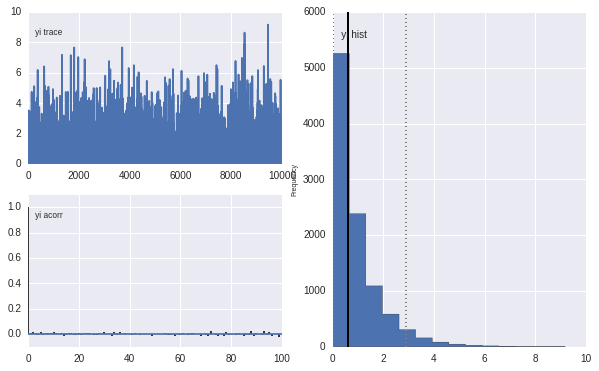

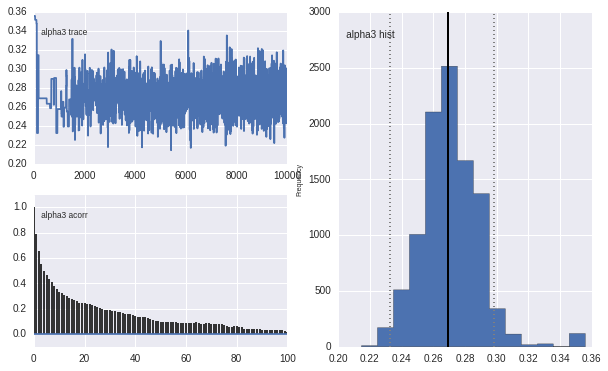

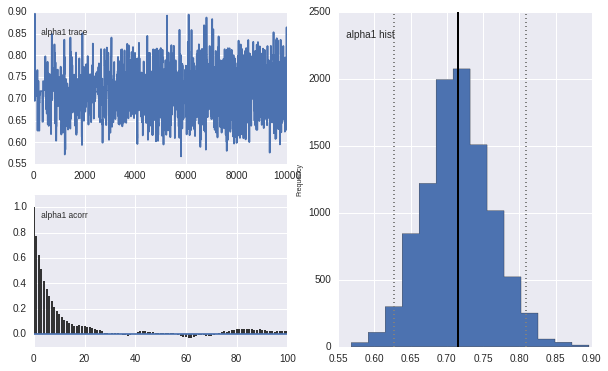

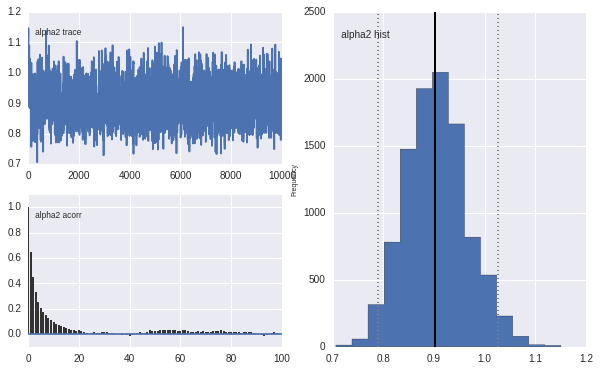

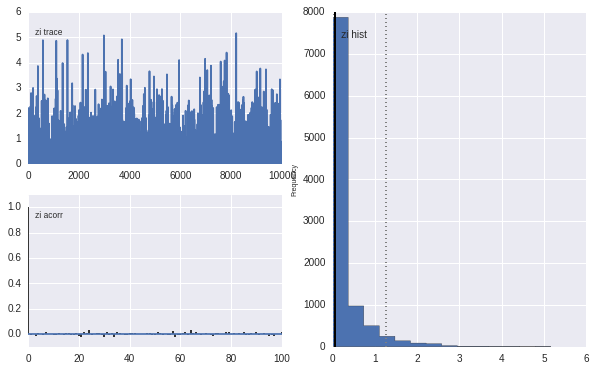

In [3]:
import matplotlib.pyplot as plt
import pymc as pymc
import numpy as np
from scipy.stats.kde import gaussian_kde
from scipy import special as sp
%matplotlib inline

# alpha ∼ Uniform(0,5)
alpha1 =  pymc.Uniform("alpha1",lower = 0, upper = 5)
alpha2 =  pymc.Uniform("alpha2",lower = 0, upper = 5)
alpha3 =  pymc.Uniform("alpha3",lower = 0, upper = 5)
    
# xi ∼ Gamma(alpha,1)
xi = pymc.Gamma("xi", alpha = alpha1, beta= 1)
yi = pymc.Gamma("yi", alpha = alpha2, beta= 1)
zi = pymc.Gamma("zi", alpha = alpha3, beta= 1)

# from Estimating a Dirichlet distribution by Thomas P. Minka

# @pymc.observed
# def Ylike(a1=alpha1,a2=alpha2,a3=alpha3,value=logpk,n=N):
#     lv = n*(np.log(sp.gamma(a1+a2+a3))-
#             (np.log(sp.gamma(a1))+np.log(sp.gamma(a2))+np.log(sp.gamma(a3)))+
#             (value[0]*(a1-1)+value[1]*(a2-1)+value[2]*(a3-1)))
#     return lv

@pymc.observed
def Ylike(a1=alpha1,a2=alpha2,a3=alpha3,value=logp,n=N):
    sumloglike=0
    for i in range(0,n):
        lv = (np.log(sp.gamma(a1+a2+a3))-
                (np.log(sp.gamma(a1))+np.log(sp.gamma(a2))+np.log(sp.gamma(a3)))+
                (value[i,0]*(a1-1)+value[i,1]*(a2-1)+value[i,2]*(a3-1)))
        sumloglike += lv
    return sumloglike

testmodel = pymc.Model([alpha1,alpha2,alpha3,xi,yi,zi,Ylike])
mcmc = pymc.MCMC(testmodel)
mcmc.sample(iter = 20000, burn = 50, thin = 2)

pymc.Matplot.plot(mcmc)


Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


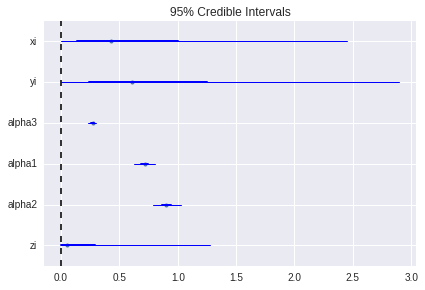

In [4]:
pymc.Matplot.summary_plot(mcmc)

Applied interval-transform to alpha1 and added transformed alpha1_interval to model.
Applied interval-transform to alpha2 and added transformed alpha2_interval to model.
Applied interval-transform to alpha3 and added transformed alpha3_interval to model.
Applied log-transform to xi and added transformed xi_log to model.
Applied log-transform to yi and added transformed yi_log to model.
Applied log-transform to zi and added transformed zi_log to model.
 [-----------------100%-----------------] 30000 of 30000 complete in 31.2 sec

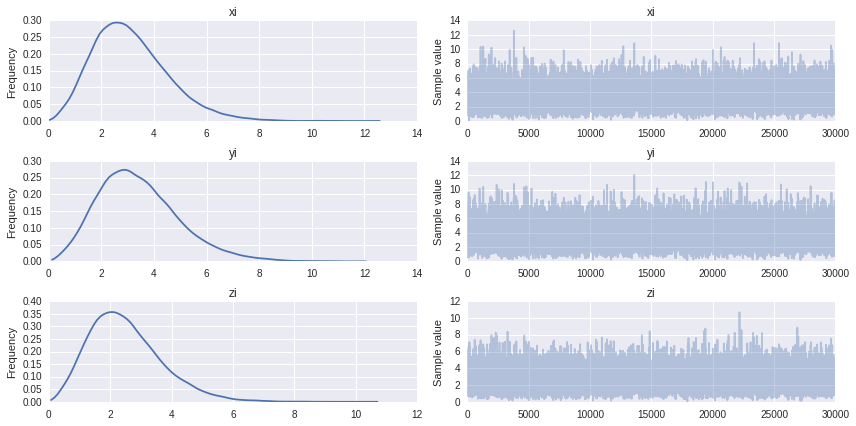

In [5]:
# using pymc3. However, here the Dirichlet likelihood function was not defined properly.
# The result could be compared with model2 in JAGS

import pymc3 as pm

model1 = pm.Model()

# prepare data
z = 5 - x - y
datmp = np.zeros((306, 3))
datmp[:,0]=x/5
datmp[:,1]=y/5
datmp[:,2]=z/5

dframe = pd.DataFrame(datmp,columns=["x", "y", "z"])
n1,n2 = dframe.shape

with model1:
    # alpha ∼ Uniform(0,5)
    alpha1 =  pm.Uniform("alpha1",lower = 0, upper = 5)
    alpha2 =  pm.Uniform("alpha2",lower = 0, upper = 5)
    alpha3 =  pm.Uniform("alpha3",lower = 0, upper = 5)
    
    # xi ∼ Gamma(alpha,1)
    xi = pm.Gamma("xi", alpha = alpha1, beta= 1)
    yi = pm.Gamma("yi", alpha = alpha2, beta= 1)
    zi = pm.Gamma("zi", alpha = alpha3, beta= 1)
    
    # observed
    xmean = pm.Deterministic("xmean",xi/(xi+yi+zi))
    ymean = pm.Deterministic("ymean",yi/(xi+yi+zi))
    zmean = pm.Deterministic("zmean",zi/(xi+yi+zi))
    
    # realization in a standard normal
    yd = pm.Normal("Observed",mu = [xmean,ymean,zmean], tau = 1,observed = dframe)
    
    #start = find_MAP()
    #h = find_hessian(start)
    
    # step = pm.Metropolis()
    # step = pm.Slice()
    step = pm.NUTS()

trace2=pm.sample(3e4, step, model=model1)

pm.traceplot(trace2[50:],varnames=['xi','yi','zi']);

/usr/local/lib/python3.4/dist-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


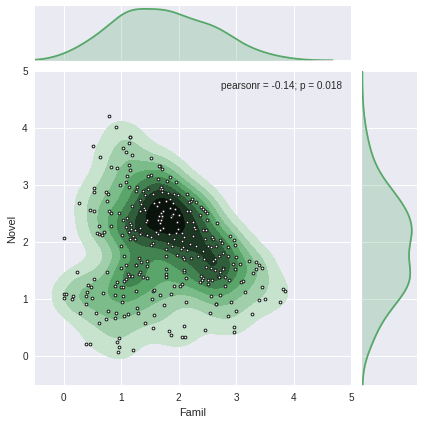

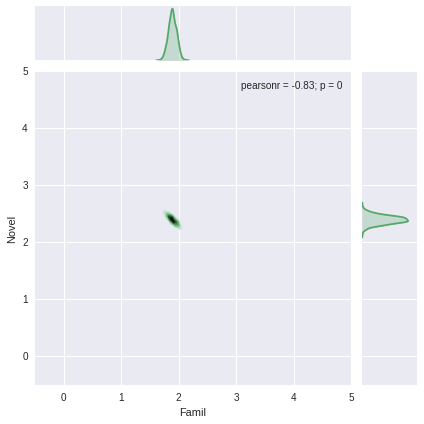

In [6]:
# xtrace = trace2['xmean'][5000::2]*5
# ytrace = trace2['ymean'][5000::2]*5

# pymc3
# xit = trace2['xi'][5000::2]
# yit = trace2['yi'][5000::2]
# zit = trace2['zi'][5000::2]

# pymc2
xit = mcmc.trace('alpha1')[5000::2]
yit = mcmc.trace('alpha2')[5000::2]
zit = mcmc.trace('alpha3')[5000::2]

xtrace = xit/(xit+yit+zit)*5
ytrace = yit/(xit+yit+zit)*5

ns1 = xtrace.shape
datmp1 = np.zeros((306, 2))
datmp1[:,0]=x
datmp1[:,1]=y

datmp2 = np.zeros((ns1[0], 2))
datmp2[:,0]=xtrace
datmp2[:,1]=ytrace

df = pd.DataFrame(datmp1,columns=["x", "y"])
# sns.jointplot(x="x", y="y", data=df);
g = sns.jointplot(x="x", y="y", data=df, kind="kde", color="g", xlim=(-.5,5), ylim=(-.5,5))
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels(label1, label2);
plt.show()

df2 = pd.DataFrame(datmp2,columns=["x", "y"])
# sns.jointplot(x="x", y="y", data=df);
g = sns.jointplot(x="x", y="y", data=df2, kind="kde", color="g", xlim=(-.5,5), ylim=(-.5,5))
# g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels(label1, label2)

plt.show()
